# K-means clustering for customers segmentation based on RFM

In this noitebook we will solve the problem of segmenting users based on their recency and frequency of purchases, as well as the amount of spending on them. The data is based on the [Online Retail](https://archive.ics.uci.edu/dataset/352/online+retail) dataset

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo 
from pathlib import Path
from scipy.stats import skew
from feature_engine.outliers import Winsorizer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pd.options.mode.chained_assignment = None

Loading the dataset

In [3]:
PATH = Path('../data/')
df = pd.read_excel(PATH / 'online_retail.xlsx')

## Data preparation

In [4]:
df.shape

(541909, 8)

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

I interpret the CustomerID variable as categorical, because it could easily be replaced string names. I also include InvoiceDate here, because it clearly has nothing to do in the description of numeric variables

In [7]:
categorical_vars = pd.concat([df.select_dtypes('object'), df.InvoiceDate, df.CustomerID], axis=1).columns
df[categorical_vars].astype('object').describe().loc['unique',:]

InvoiceNo       25900
StockCode        4070
Description      4223
Country            38
InvoiceDate     23260
CustomerID     4372.0
Name: unique, dtype: object

In [8]:
numeric_vars = np.setdiff1d(df.columns, categorical_vars)
df[numeric_vars].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


The question is why the Quantity and UnitPrice are partialy negatives. I assume that as for the Quantity variable, these are returns. And as for UnitPrice, there are only 2 lines with negative values, and the description indicates that this is a write-off of receivables (i.e., recognition of costs).

As for UnitPrice, rows with negative values will be deleted after rows with N/A values are deleted. Plus, for our purpose, writing off the debt does not matter. Regarding Quantity and returns: we leave these lines for further calculation of net receipts from clients

In [9]:
df.query('UnitPrice < 0')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


The percentage of the missing values. We delete them.

In [10]:
df.isna().sum()/len(df)

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [11]:
df.dropna(inplace=True)

Sorted percentage of the values of the Country feature

In [12]:
df.Country.value_counts(normalize=True)

United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RSA       

Filter of the most popular country (United Kingdom)

In [13]:
df_UK = df.groupby('Country').get_group('United Kingdom')
df_UK.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Creating a new feature "Date" based on the "Invoice Date": it will contain dates in a form "2021-10-24".

In [137]:
df_UK['Date'] = df_UK.InvoiceDate.dt.date
df_UK.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


## RFM (Recency-Frequency-Monetary) Analysis

The date of the last transaction

In [138]:
NOW = df_UK.Date.max()
NOW

datetime.date(2011, 12, 9)

### Recency

Creation of a recency dataframe in the R_df variable, which consists of the columns CustomerID, Last_Purchase_Date and Recency,
Where
- Last_Purchase_Date is the date of the client’s last purchase,
- Recency - how many days have passed since the customer’s last purchase until today.

In [139]:
R_df = pd.DataFrame(df_UK.groupby('CustomerID')['Date'].max())
R_df.columns = ['Last_Purchase_Date']
R_df['Recency'] = NOW - df_UK.groupby('CustomerID')['Date'].max().values

# конвертируем тип данных timedelta64[ns] в числовой формат  
R_df.Recency = R_df.Recency.astype('timedelta64[D]')

In [140]:
R_df.head()

,Last_Purchase_Date,Recency
CustomerID,,
12346.0,2011-01-18,325.0
12747.0,2011-12-07,2.0
12748.0,2011-12-09,0.0
12749.0,2011-12-06,3.0
12820.0,2011-12-06,3.0


### Frequency - Monetary

Creation of a Frequency - Monetary dataframe in the FM_df variable.
The dataframe must contain
- CustomerID - client identifier
- Frequency - number of customer purchases (number of invoices)
- Monetary - how much money the client spent in the store

Adding a new column in which we calculate the cash flow for each transaction in order to calculate the total net cash flow for each client

In [141]:
df_UK['Revenue'] = df_UK.Quantity * df_UK.UnitPrice

FM_df = pd.DataFrame(df_UK.drop_duplicates('InvoiceNo').groupby('CustomerID')['InvoiceNo'].count())
FM_df.columns = ['Frequency']
FM_df['Monetary'] = df_UK.groupby('CustomerID')['Revenue'].sum().values

In [142]:
FM_df.head()

,Frequency,Monetary
CustomerID,,
12346.0,2,0.00
12747.0,11,4196.01
12748.0,224,29072.10
12749.0,8,3868.20
12820.0,4,942.34


### RFM


Creation of a RFM_df, which is the union of R_df and FM_df by client ID.

In [264]:
RFM_df = pd.concat([R_df, FM_df], axis=1).reset_index()
RFM_df.head()

,CustomerID,Last_Purchase_Date,Recency,Frequency,Monetary
0,12346.0,2011-01-18,325.0,2,0.00
1,12747.0,2011-12-07,2.0,11,4196.01
2,12748.0,2011-12-09,0.0,224,29072.10
3,12749.0,2011-12-06,3.0,8,3868.20
4,12820.0,2011-12-06,3.0,4,942.34


## K-means for RFM segmentation

K-means gives the best result under the following conditions:
- Data distribution is not skewed (i.e. no long tails)
- Data are standardized (i.e. mean 0 and standard deviation 1).

Build data distribution charts for the Recency, Frequency and Monetary columns in RFM_df.
Print the skewness coefficient for each column.


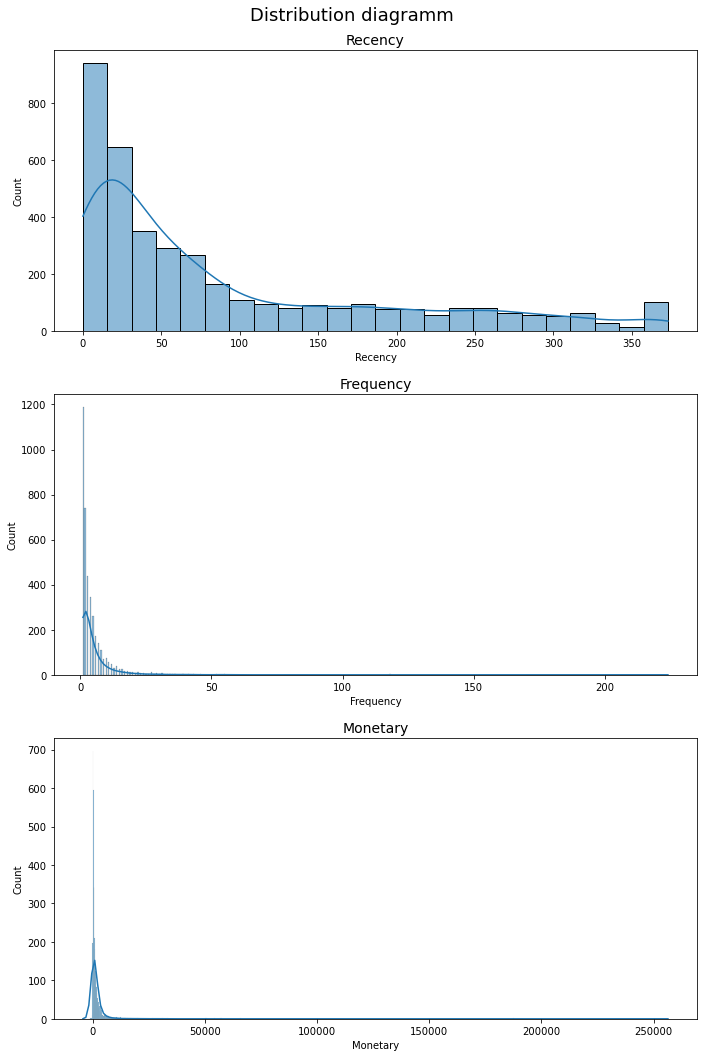

In [265]:
plt.figure(figsize=(10,15))

plt.suptitle('Distribution diagramm', fontsize=18)

plt.subplot(3,1,1)
plt.title('Recency', fontsize=14)
sns.histplot(RFM_df['Recency'], kde=True)

plt.subplot(3,1,2)
plt.title('Frequency', fontsize=14)
sns.histplot(RFM_df['Frequency'], kde=True)

plt.subplot(3,1,3)
plt.title('Monetary', fontsize=14)
sns.histplot(RFM_df['Monetary'], kde=True)

plt.tight_layout(pad=1.5);

In [266]:
sale_vars = ['Recency', 'Frequency', 'Monetary']
[print(f'{var} skewness: {skew(RFM_df[var])}') for var in sale_vars];

Recency skewness: 1.2486783576914493
Frequency skewness: 9.748333818202136
Monetary skewness: 23.337368043729484


The data is highly skewed, so we will perform a log transformation on it to reduce the skewness of each variable.

For each of the variables 'Recency', 'Frequency', 'Monetary' we perform the log(x+1) transformation.
We add a constant because the log transformation requires that all values be positive.

Display the distribution of the variables after the transformation.

In [281]:
RFM_df_log = RFM_df.copy()
RFM_df_log[sale_vars] = RFM_df[sale_vars].apply(lambda x: np.log(x+1))

# after logarithmic transformation 37 lines appeared N/A, change them to zero
RFM_df_log.fillna(0, inplace=True)
RFM_df_log.head()

C:\Users\user\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,CustomerID,Last_Purchase_Date,Recency,Frequency,Monetary
0,12346.0,2011-01-18,5.786897,1.098612,0.000000
1,12747.0,2011-12-07,1.098612,2.484907,8.342128
2,12748.0,2011-12-09,0.000000,5.416100,10.277569
3,12749.0,2011-12-06,1.386294,2.197225,8.260803
4,12820.0,2011-12-06,1.386294,1.609438,6.849427


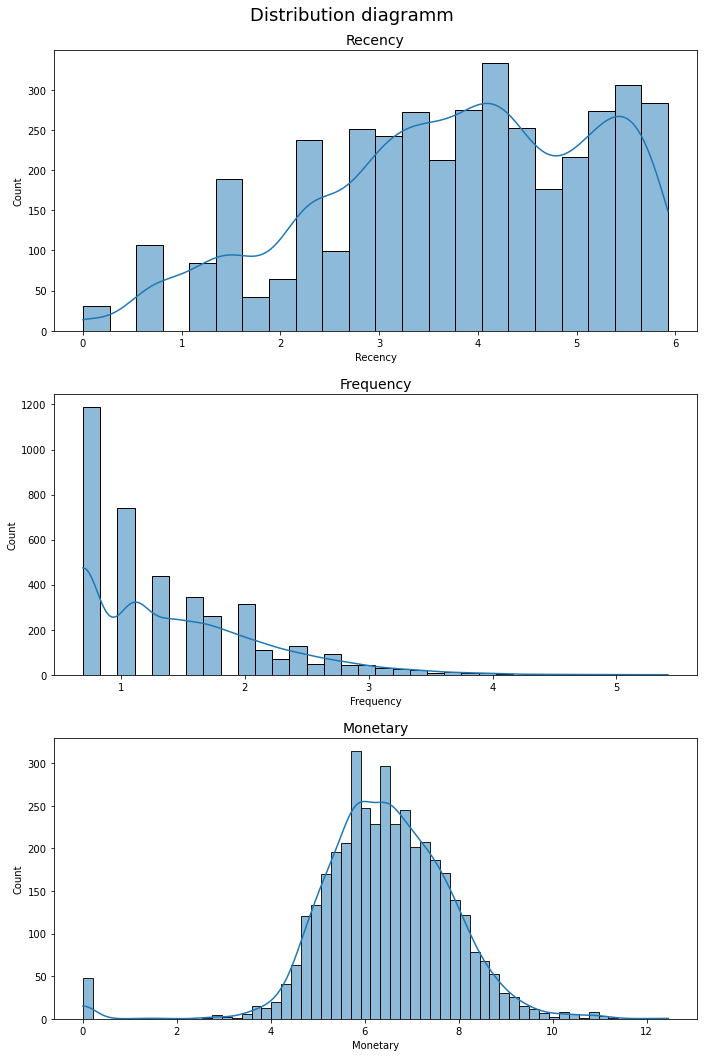

In [282]:
plt.figure(figsize=(10,15))

plt.suptitle('Distribution diagramm', fontsize=18)

plt.subplot(3,1,1)
plt.title('Recency', fontsize=14)
sns.histplot(RFM_df_log['Recency'], kde=True)

plt.subplot(3,1,2)
plt.title('Frequency', fontsize=14)
sns.histplot(RFM_df_log['Frequency'], kde=True)

plt.subplot(3,1,3)
plt.title('Monetary', fontsize=14)
sns.histplot(RFM_df_log['Monetary'], kde=True)

plt.tight_layout(pad=1.5);

In [283]:
[print(f'{var} skewness: {skew(RFM_df_log[var])}') for var in sale_vars];

Recency skewness: -0.4448625436553863
Frequency skewness: 1.0705401504529726
Monetary skewness: -0.7982113146084789


We still have here “tails” left. We'll remove them using the Winsorizing technique.
To use the technique, we will use the library feature_engine


In [284]:
windsoriser = Winsorizer(tail='both', fold=2, variables=['Recency', 'Frequency', 'Monetary'])
windsoriser.fit(RFM_df_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [285]:
RFM_windsorized = windsoriser.transform(RFM_df_log)

Plot the results

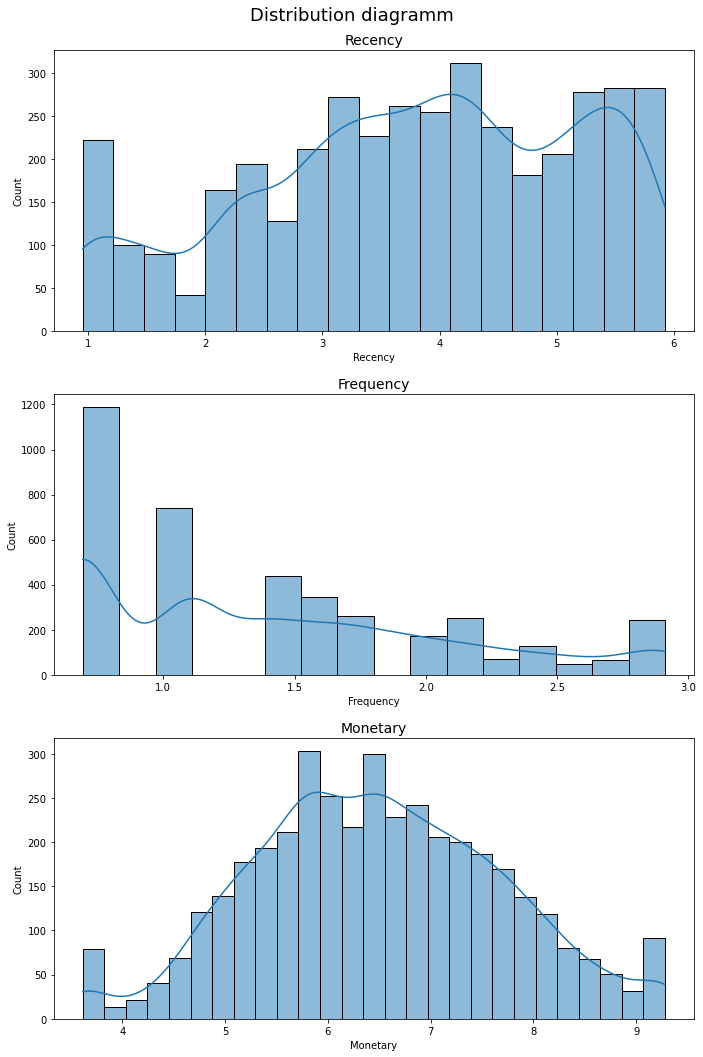

In [286]:
plt.figure(figsize=(10,15))

plt.suptitle('Distribution diagramm', fontsize=18)

plt.subplot(3,1,1)
plt.title('Recency', fontsize=14)
sns.histplot(RFM_windsorized['Recency'], kde=True)

plt.subplot(3,1,2)
plt.title('Frequency', fontsize=14)
sns.histplot(RFM_windsorized['Frequency'], kde=True)

plt.subplot(3,1,3)
plt.title('Monetary', fontsize=14)
sns.histplot(RFM_windsorized['Monetary'], kde=True)

plt.tight_layout(pad=1.5);

Standardize our RFM variables so that the average is 0 and the standard deviation is 1. There is no need to divide into train and test. We can work with the full set of data at once.

In [287]:
RFM_winds_scaled = RFM_windsorized.copy()
RFM_winds_scaled[sale_vars] = StandardScaler().fit_transform(RFM_windsorized[sale_vars])
RFM_winds_scaled.head()

,CustomerID,Last_Purchase_Date,Recency,Frequency,Monetary
0,12346.0,2011-01-18,1.456796,-0.475252,-2.353160
1,12747.0,2011-12-07,-1.954218,1.576343,1.528445
2,12748.0,2011-12-09,-2.058669,2.205899,2.298544
3,12749.0,2011-12-06,-1.744911,1.150599,1.461665
4,12820.0,2011-12-06,-1.744911,0.280725,0.302709


Find the optimal number of clusters using the Elbow Method.
We'll run KMeans clustering on prepared standardized RFM data with the K parameter from 1 to 10 inclusive.
You can do this in a loop.


We display graphically the results about the value of the sum of intracluster distances (called inertia in sklearn) for different values of K.

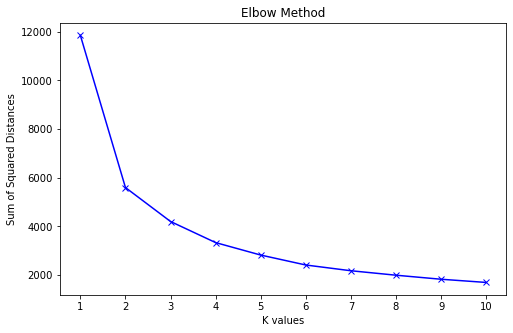

In [288]:
K = range(1,11)

sum_of_squared_distances = []

for k in K:
    model = KMeans(n_clusters=k).fit(RFM_winds_scaled[sale_vars])
    sum_of_squared_distances.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('K values')
plt.xticks(K)
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()

We create a function that will take a training data set (standardized data), a K value, and a data set with original (before standardization) values. Our goal is to use visualizations to understand which number of clusters is optimal.

Inside the function we will:
- Train on standardized Kmeans data with the number of clusters K, which is the function argument.
- Get cluster identifiers (labels).
- Create a new dataframe as a copy of original one.
- To the data set obtained in step 3, add a column with the cluster value for this row.
- Perform dimensionality reduction using TSNE.
- Display clustering results.



In [289]:
def fit_visualize_kmeans(df_rfm, clusters_number, original_df_rfm):
    model_kmeans = KMeans(n_clusters=clusters_number).fit(df_rfm)
    cluster_labels = model_kmeans.labels_
        
    df_new = original_df_rfm.copy()
    df_new['Cluster_labels'] = cluster_labels
    
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    params = dict(
        x=transformed[:,0], 
        y=transformed[:,1],
        hue=cluster_labels, 
        style=cluster_labels, 
        palette="Set1"
    )
    sns.scatterplot(**params)
    return df_new

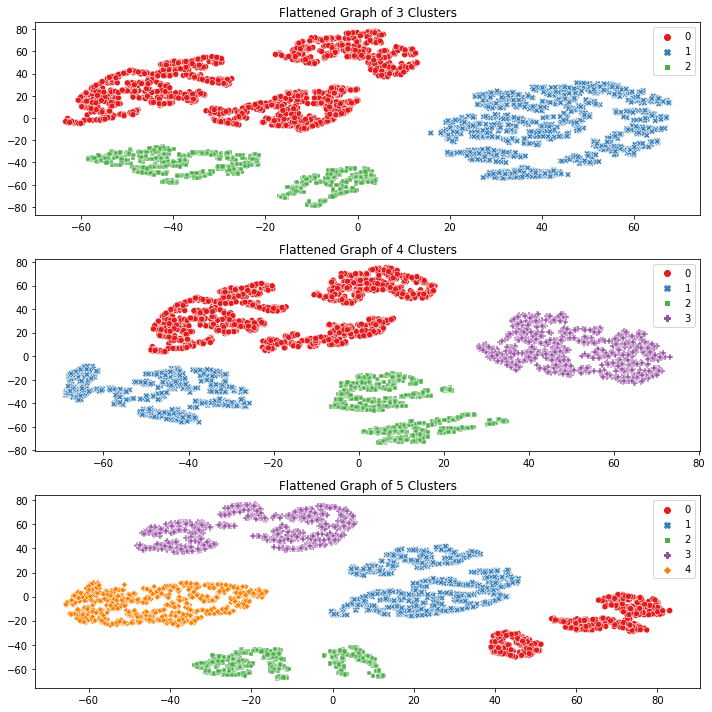

In [290]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = fit_visualize_kmeans(RFM_winds_scaled[sale_vars], 3, RFM_windsorized[sale_vars])

plt.subplot(3, 1, 2)
df_rfm_k4 = fit_visualize_kmeans(RFM_winds_scaled[sale_vars], 4, RFM_windsorized[sale_vars])

plt.subplot(3, 1, 3)
df_rfm_k5 = fit_visualize_kmeans(RFM_winds_scaled[sale_vars], 5, RFM_windsorized[sale_vars])

plt.tight_layout();

Based on the visualization, 5 clusters look more attractive

Additionally we build Snake plots. The following should happen in the function:
- Creation of a normalized dataframe, that contains the original CustomerID, standardized Recency, Frequency, Monetary values and cluster number.
- Melting and visualization of the dataframe.

We pass 2 dataframes to the function: 1) the one returned by the fit_visualize_kmeans function (from it we take the column with cluster numbers); 2) a dataframe normalized by numeric variables (we take all columns from it, except the date of the last purchase)

In [291]:
def snake_plot(df_new, df_original):
    normalised_df_rfm = pd.concat([df_original.drop('Last_Purchase_Date', axis=1), df_new.Cluster_labels], axis=1)

    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster_labels'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster_labels')

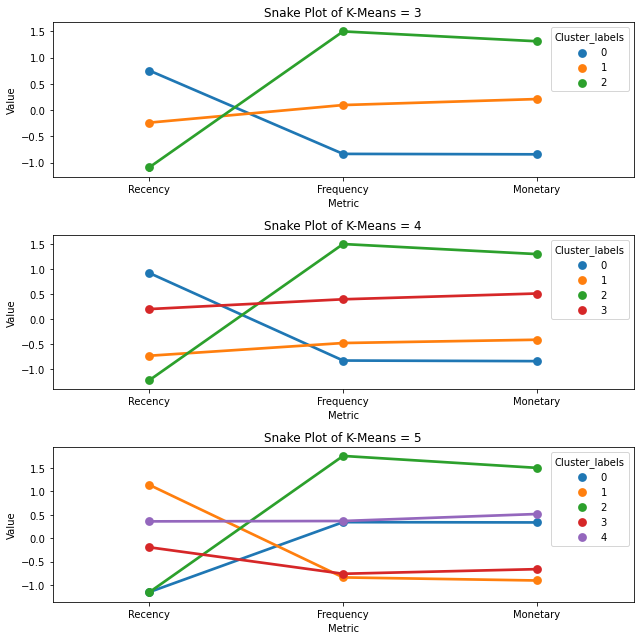

In [292]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(df_rfm_k3, RFM_winds_scaled)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(df_rfm_k4, RFM_winds_scaled)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(df_rfm_k5, RFM_winds_scaled)

plt.tight_layout()

From the smoothed and snake plots, we can see that a cluster value of 4 segments our customers well.
We could also go for more clusters, it totally depends on how the company wants to segment its customers. But usually 4 clusters are convenient.

Interpretation of the clustering results.
From the clustering results with the number of clusters 4 we form an aggregate that contains the average value for each of the three columns and the number of clients in the cluster.

In [321]:
df_rfm_k4[sale_vars] = RFM_df[sale_vars]
df_rfm_k4.groupby('Cluster_labels').agg(
    {
        'Cluster_labels' : 'count', 
        'Recency' : 'mean',
        'Frequency' : 'mean',
        'Monetary' : 'mean'
    }
)

,Cluster_labels,Recency,Frequency,Monetary
Cluster_labels,,,,
0,1400,186.613571,1.437857,290.018736
1,780,19.847436,2.158974,488.478513
2,754,10.889920,14.969496,5966.717692
3,1016,74.581693,4.796260,1458.591322


**Conclusions**

- Cluster 0: casual buyers who made a purchase a long time ago and made a small turnover; the effectiveness of targeting this cluster will be low.
- Cluster 1: promising buyers who have recently made a purchase and show good regularity; It would be good to “warm up” this group of clients more.
- Cluster 2: regular customers showing good dynamics in purchases; It is important not to lose them and regularly catch up with advertising.
- Cluster 3: brand advocates; With them, the most important thing is not to lose your reputation.